# Recurrent Neural Network - LSTM


## Part 1 - Data Preprocessing

---



### Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing

from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras import regularizers 
from keras import backend as tf

import keras.backend as K
import seaborn as sns
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.layers import *


import sys, time, random, json, pickle, itertools
import networkx as nx
import matplotlib
import scipy.stats
from sklearn.neighbors import KernelDensity
import statsmodels.stats.correlation_tools as stm
from scipy.stats import norm

import torch, torchvision
from sklearn.preprocessing import MinMaxScaler
np.random.seed(12345678)

Using TensorFlow backend.


### Import the database

In [2]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

import os
# workdir_path = '/content/drive/MyDrive/Summer 2022 RA'

workdir_path = '/Users/thnguy22/Desktop/Summer 2022 RA'
os.chdir(workdir_path)

In [3]:
# Define data files
datadir = 'dataverse_files/'
datafn_tmpl = datadir + 'sms-call-internet-mi-%4d-%02d-%02d.txt'
# datafn_idxs = [ (2013, 11, i) for i in range(1,31) ]  #+ [ (2013, 12, i) for i in range(1, 32) ] + [ (2014, 1, 1) ]
datafn_idxs = [ (2013, 11, i) for i in range(1,4) ] # + [ (2013, 12, i) for i in range(1, 32) ]# + [ (2014, 1, 1) ]
datafns = [ datafn_tmpl % x for x in datafn_idxs ]
print("Number of non-existent files:", sum([ not os.path.exists(fn) for fn in datafns ]))
outfn = datadir[:-1] + '-internet.csv'

# dataset_train = pd.read_csv('train.csv')
# training_set = dataset_train.iloc[:, 1:2].values #only column of the series itself

Number of non-existent files: 0


In [4]:
# Pick the data files to index
fns = datafns#[:10]

### Read and Preprocess Data (Save to CSV)

In [5]:
data = pd.DataFrame()
for fn in fns:
    #print('Reading file ', fn, ' ...')
    df = pd.read_csv(fn, sep="\t", header=None, names=['grid', 'time', 'country', 'sms-in', 'sms-out', 'call-in', 'call-out', 'internet'])
    df = df[ df['country'] == 39 ].drop(columns=['country', 'sms-in', 'sms-out', 'call-in', 'call-out']).fillna(0)
    data = pd.concat([ data, df ])
data = data.sort_values(by=['time', 'grid']).reset_index(drop=True)

In [6]:
# Statistics of the dataset
print("# 10min slots:", len(data['time'].unique()) )
print("Mean internet:", data['internet'].mean())
print("(Min, 5%, 25%, median, 75%, 95%, max) internet:")
print( ( data['internet'].min(), data['internet'].quantile(0.05), data['internet'].quantile(0.25), data['internet'].median(), data['internet'].quantile(0.75), data['internet'].quantile(0.95), data['internet'].max() )  )

# 10min slots: 432
Mean internet: 57.00917120201619
(Min, 5%, 25%, median, 75%, 95%, max) internet:
(0.0, 2.8526167172814505, 10.540597408945397, 26.74073901489196, 62.783427811396095, 218.33753509712272, 7936.265379884158)


In [7]:
data.to_csv(outfn)

### Load Data

In [8]:
data = pd.read_csv(outfn, index_col=0)
print("# 10min slots:", len(data['time'].unique()) )

# 10min slots: 432


/Users/thnguy22/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
# Find a grid with the maximum total demand for the prediction task
max_dmd_grid = sorted([ ( data[ data['grid']==i ]['internet'].sum(), i ) for i in range(1, 10001) ])
max_dmd_grid = list(reversed(max_dmd_grid))
gridx = max_dmd_grid[0][1]
#max_dmd_grid[:30]

In [10]:
datax = data[ data['grid'] == gridx ].reset_index(drop=True)

In [11]:
# Plot the data
datax['internet'].plot()

### Learning and Prediction

### Preparing data

In [12]:
# Parameters
total_size = len(datax.index)
train_size = int(total_size * 2 / 3)
test_size = total_size - train_size
print("Train size:", train_size, "Test size:", test_size)

Train size: 288 Test size: 144


### Train/test split

In [13]:
train = datax[:train_size]
test = datax[train_size:]

train_size=len(train)
test_size = len(test)

dataset_train = train
training_set = dataset_train.iloc[:, 2:3].values


### Time Series Graph

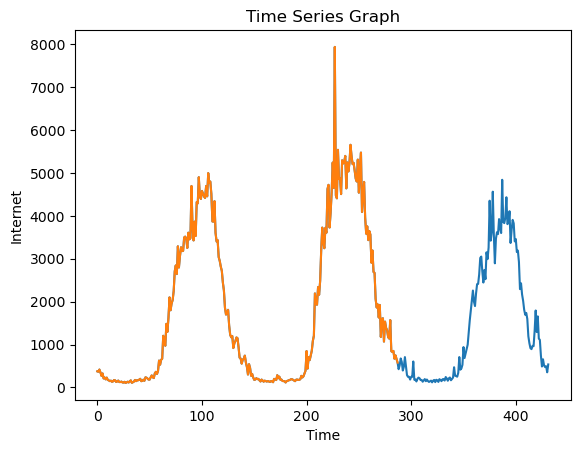

In [14]:
plt.plot(training_set)
plt.xlabel("Time")
plt.ylabel("Internet")
plt.title("Time Series Graph")
plt.show()

### Normalization



In [15]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Create the data structure with window 15 and output 1

In [16]:
window = 8
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [17]:
X_train.shape

(280, 8)

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [19]:
X_train.shape

(280, 8, 1)

## Part 2 - Construction of the RNN

### Construction of the complete network

In [20]:
# Initialize the RNN
model = Sequential()

# Add the first LSTM layer and Dropout 
model.add(GRU(units = len(train), return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))
 
# # Add the second LSTM layer and Dropout
# model.add(GRU(units = window, return_sequences = True))
# model.add(Dropout(0.2))

# Add the second LSTM layer and Dropout
model.add(GRU(units = window, return_sequences = False))
model.add(Dropout(0.1))


# Output layer
model.add(Dense(units = 1))
 
# Compile the network
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Summarize the network
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 8, 288)            250560    
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 288)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 8)                 7128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 257,697
Trainable params: 257,697
Non-trainable params: 0
_________________________________________________________________


### Training

In [21]:
model.fit(X_train, y_train, epochs = 150, batch_size = 128)

Epoch 1/150
280/280 [==============================] - 2s 9ms/step - loss: 0.0836
Epoch 2/150
280/280 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 3/150
280/280 [==============================] - 0s 1ms/step - loss: 0.0224
Epoch 4/150
280/280 [==============================] - 0s 1ms/step - loss: 0.0073
Epoch 5/150
280/280 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 6/150
280/280 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 7/150
280/280 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 8/150
280/280 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 9/150
280/280 [==============================] - 0s 1ms/step - loss: 0.0071
Epoch 10/150
280/280 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 11/150
280/280 [==============================] - 0s 1ms/step - loss: 0.0063
Epoch 12/150
280/280 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 13/150


## Part 3 - Making predictions and analyzing the results

### Test base

In [22]:
dataset_test = test
test_pul = dataset_test.iloc[:, 2:3].values

### Build the framework for testing

In [23]:
dataset_total = pd.concat((dataset_train.iloc[:,2], dataset_test.iloc[:,2]), axis = 0)

testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Make the predictions


In [24]:
predicted = model.predict(X_test)
#model.save_weights('weightsfile_gru.h5')
#existingModel.load_weights('weightsfile.h5')
predicted = sc.inverse_transform(predicted)

In [25]:
# print(len(predictions))
# print(predictions.shape)

In [26]:
# x = np.arange(test_size)

### Visualization of training and test results

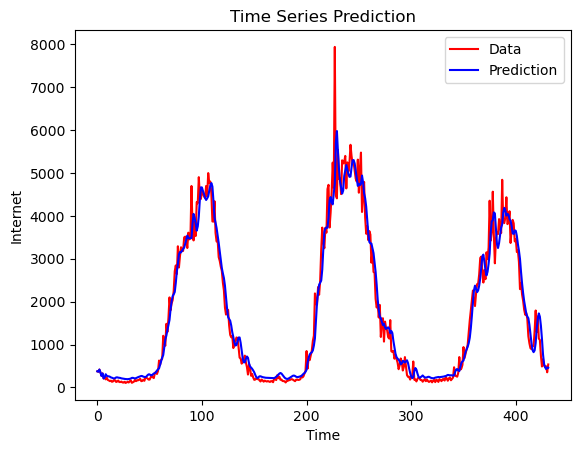

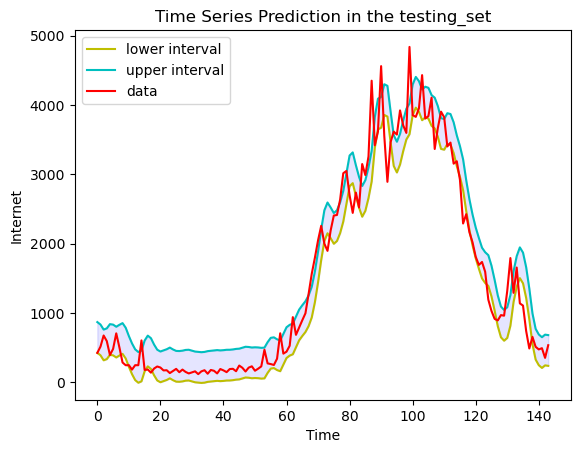

In [27]:
allTargetData = np.vstack((training_set, test_pul))
training_predicted = model.predict(X_train)
training_predicted = sc.inverse_transform(training_predicted)
allForecastedData = np.vstack((training_set[0:window], training_predicted, predicted))
plt.plot(allTargetData, color = 'red', label = 'Data')
plt.plot(allForecastedData, color = 'blue', label = 'Prediction')
plt.xlabel("Time")
plt.ylabel("Internet")
plt.title("Time Series Prediction")
plt.legend()
# plt.savefig('predictions_training_test.svg')
plt.show()

from matplotlib import pyplot as plt
import numpy as np

x = np.arange(test_size)
y = predicted.reshape(-1,)
ci = 1.96 * np.std(predicted)/np.sqrt(len(x))

fig, ax = plt.subplots()
# ax.plot(x,y, 'b')
ax.plot(x, y-ci, color = 'y', label = 'lower interval')
ax.plot(x, y+ci, 'c', label = 'upper interval')
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
ax.plot(x,test_pul.reshape(-1,),'r', label = 'data')
plt.xlabel("Time")
plt.ylabel("Internet")
plt.title("Time Series Prediction in the testing_set")
plt.legend()
plt.show()

## Part 4 - Evaluation Metrics


In [28]:
rmse = math.sqrt(mean_squared_error(test_pul, predicted))
print('RMSE: ', rmse)

RMSE:  313.02202986829155


In [29]:
mse = mean_squared_error(test_pul, predicted)
print('MSE: ',mse)

MSE:  97982.79118286562


In [30]:
mape = np.mean(np.abs((test_pul - predicted) / test_pul)) * 100
print('MAPE: ',mape, '%')

MAPE:  31.36951249509711 %


In [31]:
mae = mean_absolute_error(test_pul, predicted)
print('MAE: ',mae)

MAE:  226.94872778015235


### Statistics of the test results.

### Using the mean (predicted)

In [32]:
# Fraction of under-estimated demands using the mean (predicted)
violated = (predicted < test_pul)
violations = (test_pul - predicted)[violated]
print('Total violations:', sum(violated), '(%.2f%% of the test data points)' % (100*sum(violated)/test_size) )

Total violations: [43] (29.86% of the test data points)


In [33]:
print('Demand mean:', np.mean(test_pul))
print('Violation mean:', np.mean( violations ) )
print('Violation excess: %.2f%%' % (100 * np.mean( violations ) / np.mean(test_pul)) )

Demand mean: 1468.3849718643323
Violation mean: 300.93227119370124
Violation excess: 20.49%


### Using higher 95% confidence interval

In [34]:
ninety_fine_ci_higher = (y+ci).reshape(-1,1)
# Fraction of under-estimated demands using higher 95% confidence interval
violated_higher = (ninety_fine_ci_higher < test_pul)
violations_higher = (test_pul - ninety_fine_ci_higher)[violated_higher]
print('Total violations:', sum(violated_higher), '(%.2f%% of the test data points)' % (100*sum(violated_higher)/test_size) )

Total violations: [25] (17.36% of the test data points)


In [35]:
print('Demand mean:', np.mean(test_pul))
print('Violation mean:', np.mean( violations_higher ) )
print('Violation excess: %.2f%%' % (100 * np.mean( violations_higher) / np.mean(test_pul)) )

Demand mean: 1468.3849718643323
Violation mean: 227.57334631658284
Violation excess: 15.50%


### Using lower 95% confidence interval

In [36]:
ninety_fine_ci_lower = (y-ci).reshape(-1,1)
# Fraction of under-estimated demands using higher 95% confidence interval
violated_lower = (ninety_fine_ci_lower < test_pul)
violations_lower = (test_pul - ninety_fine_ci_lower)[violated_lower]
print('Total violations:', sum(violated_lower), '(%.2f%% of the test data points)' % (100*sum(violated_lower)/test_size) )

Total violations: [114] (79.17% of the test data points)


In [37]:
print('Demand mean:', np.mean(test_pul))
print('Violation mean:', np.mean( violations_lower ) )
print('Violation excess: %.2f%%' % (100 * np.mean( violations_lower) / np.mean(test_pul)) )

Demand mean: 1468.3849718643323
Violation mean: 271.24064522985367
Violation excess: 18.47%


In [38]:
from scipy import stats
from scipy.stats import norm

In [39]:
ci = stats.norm.interval(0.95,np.mean(predicted),np.std(predicted)/(1738**0.5))
print('95% CI is:',ci)

95% CI is: (1451.7740922925118, 1579.4463666918632)
